# Orienteering

## DEFINIZIONE
Il problema dell'Orienteering è una variante del classico problema del commesso viaggiatore.
Il TSP classico prevede un grafo $G(V,A)$ a cui è associato un costo $d_{ij}$ ad ogni arco $(i,j) \in A$. L'obiettivo è tradizionalmente quello di trovare il circuito hamiltoniano (un ciclo che attraversa tutti i nodi del grafo una ed una sola volta) a costo minimo.

L'ORIENTEERING nasce come uno sport da fare in luoghi aperti come montagne o aree con foreste particolarmente fitte. I partecipanti partono da un punto e devono visitare quanti più control point possibili in un tempo limitato per poi tornare al control point specificato (spesso quello iniziale).

Le differenze rispetto al TSP tradizionale, quindi, sono:
-   Ad ogni punto di controllo vengono assegnati dei punti (nel codice sono assegnati in modo casuale)
-   Il tempo limitato potrebbe non permettere ai partecipanti di esplorare tutti i control point (nodi), quindi essi devono decidere quali punti di controllo esplorare per masimizzare il loro punteggio

In definitiva, possiamo descrivere il problema dell'Orienteering nel seguente modo:
*Dati n nodi in uno spazio Euclideo, associati ad ognuno di essi un punteggio $s_i >= 0$ (con $s_1=0$), trovare il ciclo che permetta di massimizzare il punteggio ottenuto visitando i nodi partendo dal nodo 1 e terminando nel nodo 1 in un tempo non maggiore di TMAX*

### Caricamento dataset

In [ ]:
f = open('eil76.tsp', 'r')

NNodes = 0
Coord = []

for line in f:
    if line.startswith("DIMENSION"):
        NNodes = int(line.split(":")[1])
    elif line.startswith("NODE_COORD_SECTION"):
        break

for line in f:
    if line.startswith("EOF"):
        break
    elif line[0].isdigit():
        data = list(map(float,line.split(" ")[1:]))
        Coord.append(data)
        
print(NNodes == len(Coord))
print(NNodes)
print(len(Coord))

True
76
76


### Generazione score e distanze

In [ ]:
import math
import random
from scipy.spatial import distance
score = [0, 82, 113, 151, 143, 168, 164, 5, 491, 422, 238, 441, 367, 169, 50, 267, 498, 428, 145, 395, 390, 39, 451, 175, 472, 412, 265, 468, 485, 193, 298, 471, 274, 238, 450, 236, 349, 119, 499, 182, 59, 301, 277, 460, 149, 212, 76, 26, 142, 57, 287, 439, 297, 3, 233, 76, 98, 314, 84, 438, 165, 398, 471, 472, 433, 203, 294, 387, 10, 108, 359, 342, 136, 143, 470, 72, 200, 328, 454, 306, 79, 221, 481, 226, 438, 158, 243, 132, 278, 20, 183, 12, 102, 227, 87, 421, 34, 344, 122, 206, 26, 428, 75, 186, 14, 255, 375, 110, 338, 70, 439, 326, 407, 313, 370, 412, 251, 375, 354, 114, 362, 442, 9, 492, 108, 6, 446, 27, 280, 304, 295, 319, 225, 334, 238, 186, 428, 376, 194, 330, 22, 277, 162, 330, 415, 16, 36, 50, 243, 66, 93, 22, 250, 394, 151, 411, 204, 305, 279, 147, 446, 4, 6, 180, 406, 385, 331, 469, 177, 337, 372, 26, 141, 147, 33, 358, 373, 21, 406, 61, 302, 374, 436, 319, 465, 157, 177, 31, 342, 75, 409, 243, 130, 320, 290, 284, 179, 343]
RMAXSCORE = max(score)
#for i in range(NNodes):
    #Score.append(random.randint(1,500))
#Score[0] = 0 #il nodo di partenza ha score 0
#print(Score)

Dist = {(i, j): distance.euclidean(Coord[i], Coord[j])  for i in range(NNodes) for j in range(NNodes) if i != j}
#cosi non genero le chiavi con due valori uguali: (0,0), (1,1) ecc, dato che non esistono autoanelli
RMAXDIST = max(Dist.values())
print(len(score))

198


### Formulazione
Le variabili utilizzate sono:
- $x_{ij}$: 1 se l'arco $(i,j)$ appartiene al percorso seguito dal concorrente, 0 altrimenti
- $y_i$: 1 se il nodo $i$ è visitato, 0 altrimenti

In [ ]:
import numpy as np
import gurobipy as gp
from gurobipy import GRB

mod = gp.Model('Orienteering')
mod.reset()
xvars = mod.addVars(Dist.keys(), name='x', vtype=GRB.BINARY)
yvars = mod.addVars(int(NNodes), name='y', vtype=GRB.BINARY)

Set parameter Username
Academic license - for non-commercial use only - expires 2022-07-21
Discarded solution information


### Vincoli
- Il nodo origine deve avere un arco uscente ed uno entrante (originOut e originIn)

\begin{equation}
\sum_{j:(1,j) \in A} x_{1j} = 1 \quad 
\tag{1}
\end{equation}

\begin{equation}
\sum_{i:(i,1) \in A} x_{i1} = 1 \quad 
\tag{2}
\end{equation}
 
- Per ogni altro nodo, se selezioniamo un arco entrante dobbiamo selezionare anche un arco uscente (flowInOut)

\begin{equation}
\sum_{i:(i,j) \in A} x_{ij} = \sum_{i:(j,i) \in A} x_{ji} \quad \quad j \in V 
\tag{3}
\end{equation}

- Il nodo $j$ è visitato se ha un arco entrante (visited)

\begin{equation}
\sum_{i:(i,j) \in A} x_{ij} = y_j \quad \quad j \in V 
\tag{4}
\end{equation}

- Definito TMAX, il circuito perscorso non può avere una durata maggiore di TMAX (maxTime)

\begin{equation}
\sum_{(i,j) \in A} d_{ij} x_{ij} \leq TMax
\tag{5}
\end{equation}





In [ ]:
#VINCOLI
# * = somma su quel parametro
originOut = mod.addConstr(xvars.sum(0, '*') == 1) #Vincolo 1

originIn = mod.addConstr(xvars.sum('*', 0) == 1) #Vincolo 2

flowInOut = mod.addConstrs(xvars.sum('*', j) == xvars.sum(j, '*') 
                           for j in range(NNodes)) #Vincolo 3

visited = mod.addConstrs(xvars.sum('*',j) == yvars[j] 
                         for j in range(NNodes)) #Vincolo 4

TMAX = 500

maxTime = mod.addConstr(gp.quicksum(Dist[(i,j)]*xvars[i,j] 
    for i in range(NNodes) for j in range(NNodes) if i!=j) <= TMAX) #Vincolo 5

- Vincoli di assenza di sottogiro: ci serviremo di variabili di posizione (Uvars) e aggiungendo
\begin{equation}
u_1=0
\tag{6}
\end{equation}

\begin{equation}
0 \leq u_i \leq n-1 
\tag{7}
\end{equation}

\begin{equation}
u_j - u_i \geq 1 - n(1-x_{ij}) \quad \quad i,j \in V, i \neq j , j \neq 1
\tag{8}
\end{equation}
- Considerate i e j, possono esserci due situazioni
- Visito prima i poi subito dopo j, quindi l'arco è attivo dato che i e j sono collegati$x_{ij} = 1 \Rightarrow u_j\geq u_i + 1$ 
- Non vado da i subito dopo in j, quindi l'arco non è attivo
$x_{ij} = 0\Rightarrow u_j\geq u_i - (n-1)$. Ma dato che ciascuna variabile $u_i$ varia tra 0 ed n-1, allora questo vincolo non dice nulla

In [ ]:
#Crea le varibili di posizione
uvars = mod.addVars(NNodes, lb=0.0, ub=NNodes, vtype=GRB.INTEGER, name='u')
PositionIni = mod.addConstr(uvars[0] == 0)
Positions = mod.addConstrs(uvars[j] - uvars[i] - NNodes*xvars[i,j] >= 1 - NNodes 
                                     for i in range(NNodes) for j in range(NNodes) if i != j and j != 0) 
    

### Funzione obiettivo
L'obiettivo dell'Orienteering è quello di massimizzare lo score ottenuto, quindi:

\begin{equation}
max \sum_{i \in V} s_i y_i 
\end{equation}


In [ ]:
mod.setObjective(gp.quicksum(score[i]*yvars[i] for i in range(NNodes)), GRB.MAXIMIZE)
mod.optimize()

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 5781 rows, 5852 columns and 39902 nonzeros
Model fingerprint: 0xa10c34dc
Variable types: 0 continuous, 5852 integer (5776 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+01]
  Objective range  [3e+00, 5e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 5e+02]
Found heuristic solution: objective 395.0000000
Presolve removed 3 rows and 2 columns
Presolve time: 0.12s
Presolved: 5778 rows, 5850 columns, 33989 nonzeros
Variable types: 0 continuous, 5850 integer (5775 binary)

Root relaxation: objective 1.969400e+04, 2270 iterations, 0.22 seconds (0.17 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 19694.0000    0  140  395.00000 19694.0000  4886%     -    0s
H    0     0           

In [ ]:
#Funzioni di supporto
from itertools import chain, combinations
import matplotlib
import matplotlib.pyplot as plt
#%matplotlib notebook
#calcola il tempo dalla lista di nodi nel tour
def calcTime(T):
    N = len(T)
    c = sum([Dist[ ( T[i], T[i+1] ) ] for i in range(N-1)])
    return c + Dist[(T[-1],0)]

#calcola il tempo dalla variabile di selezione degli archi xij
def calcTime2():
    return sum([ Dist[key] for key,value in xvals.items() if value>0.5])

#calcola lo score dalla lista di nodi nel tour
def calcScore(T):
    N = len(T)
    return sum([score[T[i]] for i in range(N)])

#calcola il tempo dalla variabile di selezione dei nodi yi
def calcScore2():
    return sum([ score[key] for key,value in yvals.items() if value>0.5])

def plotTour(T,title,dim): #plot della soluzione dal tour
    plt.figure(figsize=(dim,dim))
    for i in range(0,int(NNodes)):
        plt.scatter(Coord[i][0],Coord[i][1])
        plt.text(Coord[i][0],Coord[i][1], str(i),fontsize=12)

    for i in range(0,len(T)-1):
        plt.plot([Coord[T[i]][0],Coord[T[i+1]][0]],
                 [Coord[T[i]][1],Coord[T[i+1]][1]])  

    plt.plot([Coord[T[len(T)-1]][0],Coord[T[0]][0]],
             [Coord[T[len(T)-1]][1],Coord[T[0]][1]])

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.suptitle(title, fontsize=20)
    
def plotSolution(Solution,title, dim): #plot della soluzione dalla var xij
    plt.figure(figsize=(dim,dim))
    for i in range(0,int(NNodes)):
        plt.scatter(Coord[i][0],Coord[i][1])
        plt.text(Coord[i][0],Coord[i][1], str(i),fontsize=12)
            
    for i in range(0,len(Solution)):
        plt.plot([Coord[Solution[i][0]][0],Coord[Solution[i][1]][0]],
                 [Coord[Solution[i][0]][1],Coord[Solution[i][1]][1]])  
                    
    plt.xlabel('X');
    plt.ylabel('Y');
    plt.suptitle(title, fontsize=20)


### Estrazione della soluzione

In [ ]:
xvals = mod.getAttr('x', xvars)
yvals = mod.getAttr('x', yvars)
uvals = mod.getAttr('x', uvars)


#cancella da uvals, le ui dove il nodo i non è stato usato, cioè yvals[i]==0
#mantiene quindi solo le ui dove il nodo i è stato usato yvals[i]>0.5
#itera con chiave,valore, dove chiave = i, valore = ui
#OSS: il valore degli ui può avere anche salti, cioè posso avere anche salti
#però sono sicuro che il valori ui dei nodi i usati, cioè con yi = 1
#messi in ordine, mi danno l'ordine del tour, cioè se visito il nodo
#10 prima del nodo 40, allora u40 >= u10 + 1
#per costruzione se visito i nodi 2,3,5,8,9
#sono sicuro che u9>u8>u5>u3>u2
uvals = dict({(k,v) for k,v in uvals.items() if yvals[k]>0.5})
#ordina sul valore ui, cosi da ottenere delle coppie i,ui ordinate sul valore ui
sortedPos = dict(sorted(uvals.items(), key=lambda item:item[1]))
#dopo aver ordinato, per sapere i nodi basta estrarre le chiavi già ordinate
bestTour = list(sortedPos.keys())
bestScore = calcScore(bestTour)
notPass = list([k for k,v in yvals.items() if v<0.5])
#nodi non visitati si potevano anche estrarre con yvals[i]<0.5

print(bestTour)
print(calcTime(bestTour))
print(calcScore(bestTour))  
print(calcTime2())  
print(calcScore2())
print(notPass)


[0, 61, 72, 32, 62, 15, 2, 43, 31, 8, 38, 71, 11, 39, 16, 50, 5, 67, 74, 75, 25, 66, 3, 44, 28, 47, 29, 1, 73, 27, 60, 20, 46, 35, 70, 59, 69, 19, 36, 4, 14, 56, 12, 26, 51, 33, 45, 6, 34, 18, 13, 52, 10, 65, 64, 37, 57, 9, 30, 54, 24, 49, 17, 23, 48, 22, 55, 40, 63, 41, 42]
499.61810784001176
19553
499.6181078400119
19553
[7, 21, 53, 58, 68]


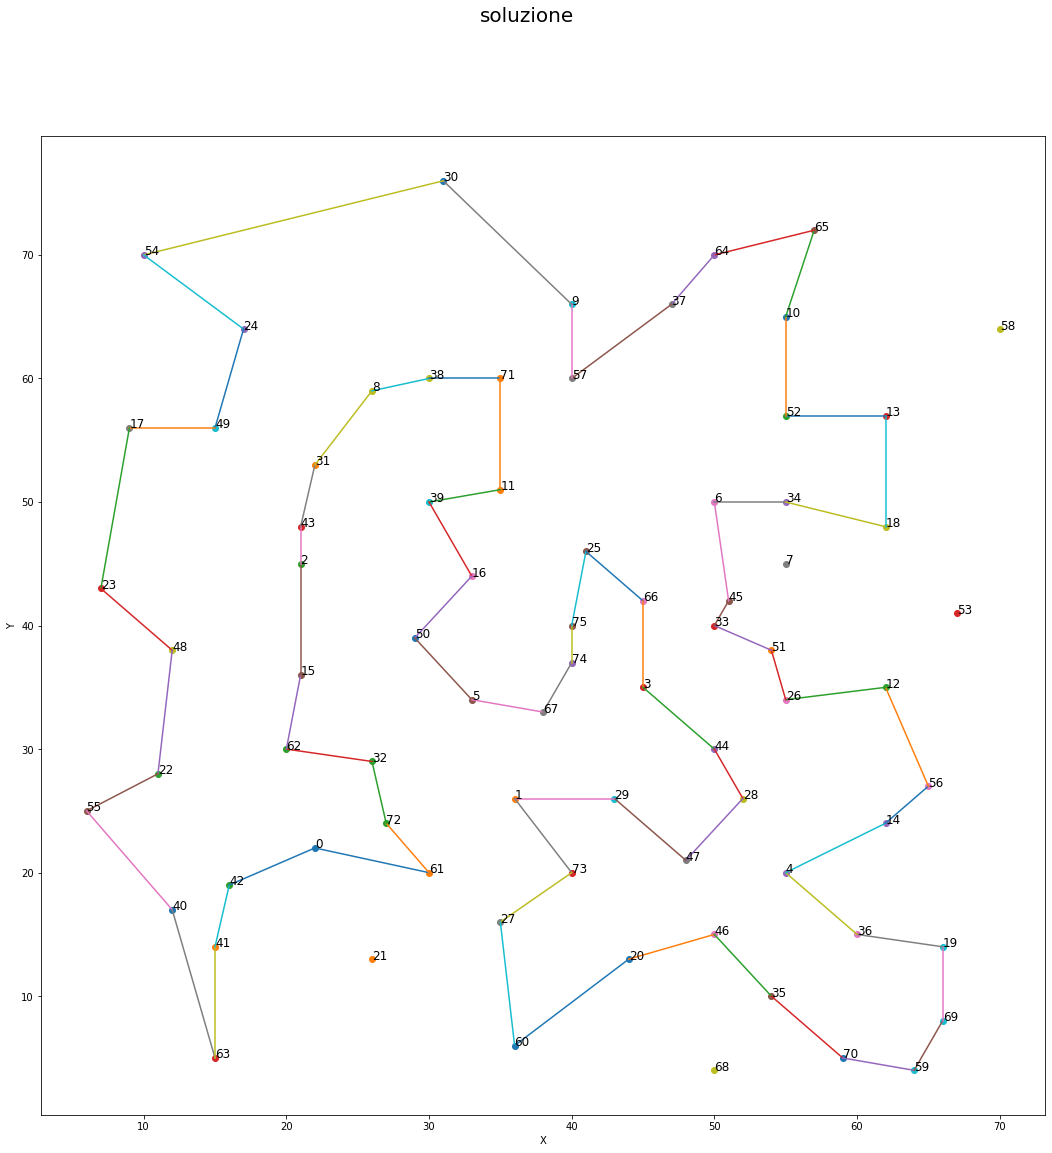

In [ ]:
plotTour(bestTour,"soluzione",18)

### Salvataggio soluzione

In [ ]:
mod.write("bier127lazy.lp")
mod.write("bier127lazy.sol")

## Euristiche greedy
La funziona getBest è utilizzata dalle euristiche greedy implementate, prende in ingresso 3 parametri tra cui
- T: insieme dei nodi presenti nella soluzione
- funcScore: funzione che associa ad un nodo un indice, ogni euristica specifica la sua metrica
- checkValid: funzione per valutare se una generica soluzione parziale è valida

getBest ricava la lista dei nodi esterni alla soluzione parziale, elimina i nodi che aggiunti alla soluzione parziale la renderebbero non valida (>=TMAX), assegna ad ogni nodo valido un indice tramite funcScore e restituisce il miglior nodo candidato

In [ ]:
def getBest(T, funcScore, checkValid):
    validNodes = list(set(list(range(NNodes)))-set(T)) #calcolo nodi esterni
    validNodes = list(filter(checkValid, validNodes)) #rimuovo i nodi che sforano TMAX
    #se non ci sono nodi validi, termina
    if len(validNodes)==0:
        return None
    #crea una lista fatta di coppie [(Nodo,valoreIndice),(Nodo,valoreIndice),()...]
    ordNodes = list(zip(validNodes, [funcScore(i,T) for i in validNodes])) 
    bestNode = max(ordNodes,key=lambda item:item[1])[0] #estrae il nodo con il nodo migliore e lo restituisce
    return bestNode

greedyOut = []

### Alg1
In questa prima euristica partendo dal nodo origine, si valuta la lista dei nodi non presenti nel tour, vengono eliminati i nodi che non rispettano il vincolo temporale del problema. Infine per ogni nodo viene valutato l'indice ottenuto dal rapporto tra la score del nodo e la distanza dall'ultimo nodo attuale del tour, si ordinano i nodi in ordine decrescente in funzione dell'indice calcolato (scelta greedy) e si prende il primo nodo della lista se essa non è vuota

Time: 494.31520845396443
Score: 17148
gap(12.299903%)
[0, 62, 22, 42, 41, 63, 27, 61, 32, 15, 43, 31, 8, 38, 71, 57, 9, 64, 10, 52, 34, 51, 26, 28, 44, 74, 67, 16, 11, 25, 66, 33, 45, 12, 19, 36, 59, 70, 35, 20, 73, 29, 3, 50, 5, 24, 17, 54, 23, 48, 72]


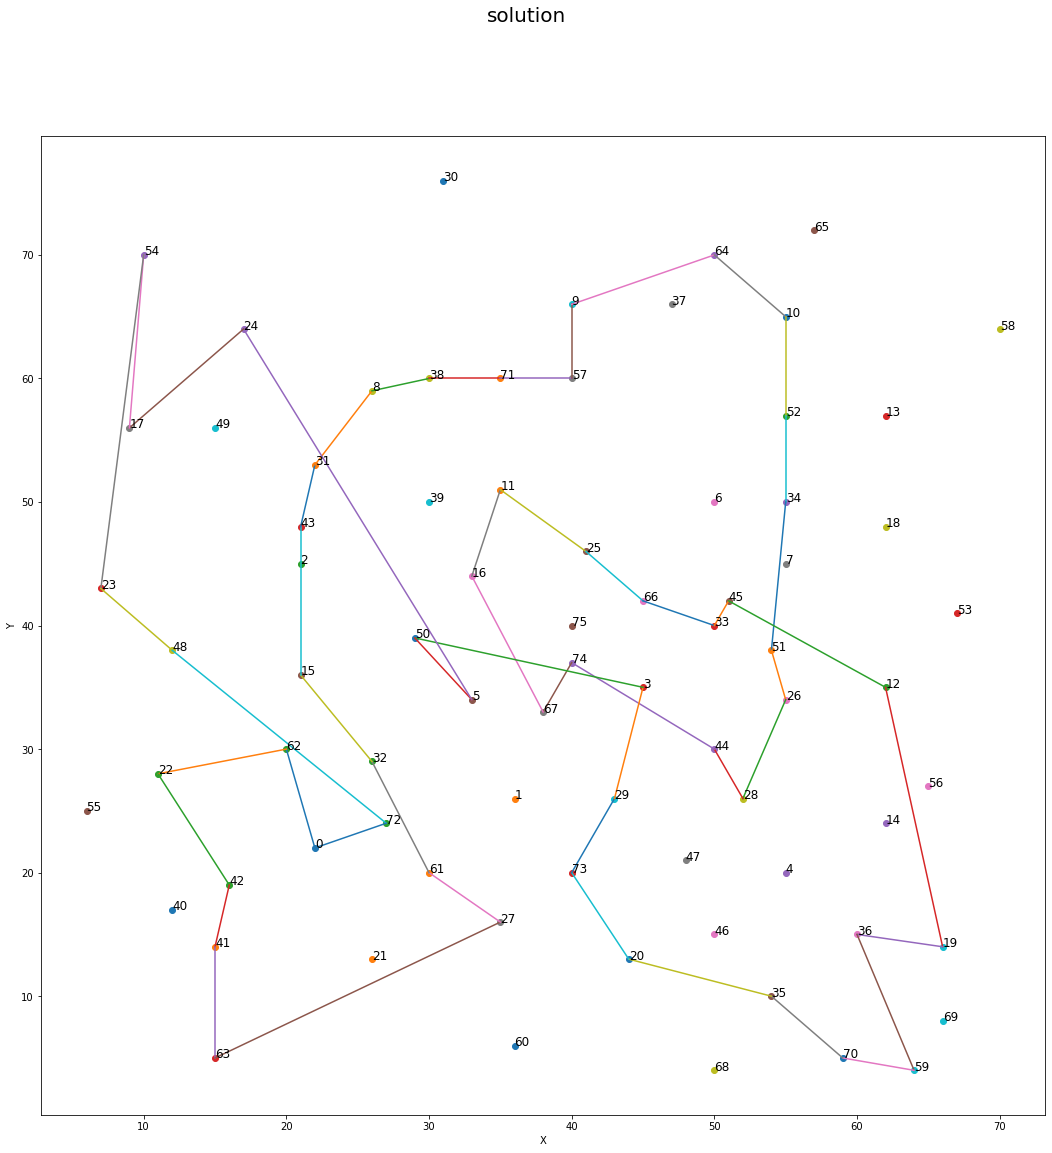

In [ ]:
Tour1 = [0]

#calcola il tempo residuo 
#TMAX - tempo del percorso attuale
def getTimeLeft(T):
    N = len(T)
    c = 0
    for i in range(N-1):
        c = c + Dist[ ( T[i], T[i+1] ) ]
    return TMAX-c

#ad ogni nodo i è assegnato un indice pari
#al rapporto tra score e distanza tra il nodo i
#e l'ultimo nodo di T
def funcScore1(i,T):
    return score[i]/Dist[(T[-1],i)]

#se aggiungo x come prossimo nodo
#la distanza last->x->origine, rientra nel tempo rimanente?
def isValid1(x):
    return Dist[(Tour1[-1], x)] + Dist[(x,0)] <= getTimeLeft(Tour1)

while True:
    nextNode = getBest(Tour1,funcScore1,isValid1)
    if nextNode is None:
        break
    Tour1.append(nextNode)
    
gap =  float((bestScore-calcScore(Tour1))*(100/bestScore))
print("Time:",calcTime(Tour1))
print("Score:",calcScore(Tour1))
print("gap(%f%%)" % ( gap ) )
print(Tour1)
greedyOut.append((calcScore(Tour1),gap))
plotTour(Tour1,"solution",18)



### Alg2
Utilizza solo la distanza per la scelta

Time: 499.9688711326333
Score: 17008
gap(13.015905%)
[0, 72, 61, 27, 73, 29, 1, 67, 74, 75, 66, 33, 45, 7, 34, 6, 52, 13, 18, 53, 12, 26, 51, 44, 28, 47, 46, 20, 35, 70, 59, 69, 19, 36, 4, 14, 56, 3, 25, 11, 39, 16, 50, 5, 32, 62, 15, 2, 43, 31, 8, 38, 71, 57, 9, 37, 64, 10, 65, 58, 30, 24, 49, 48]


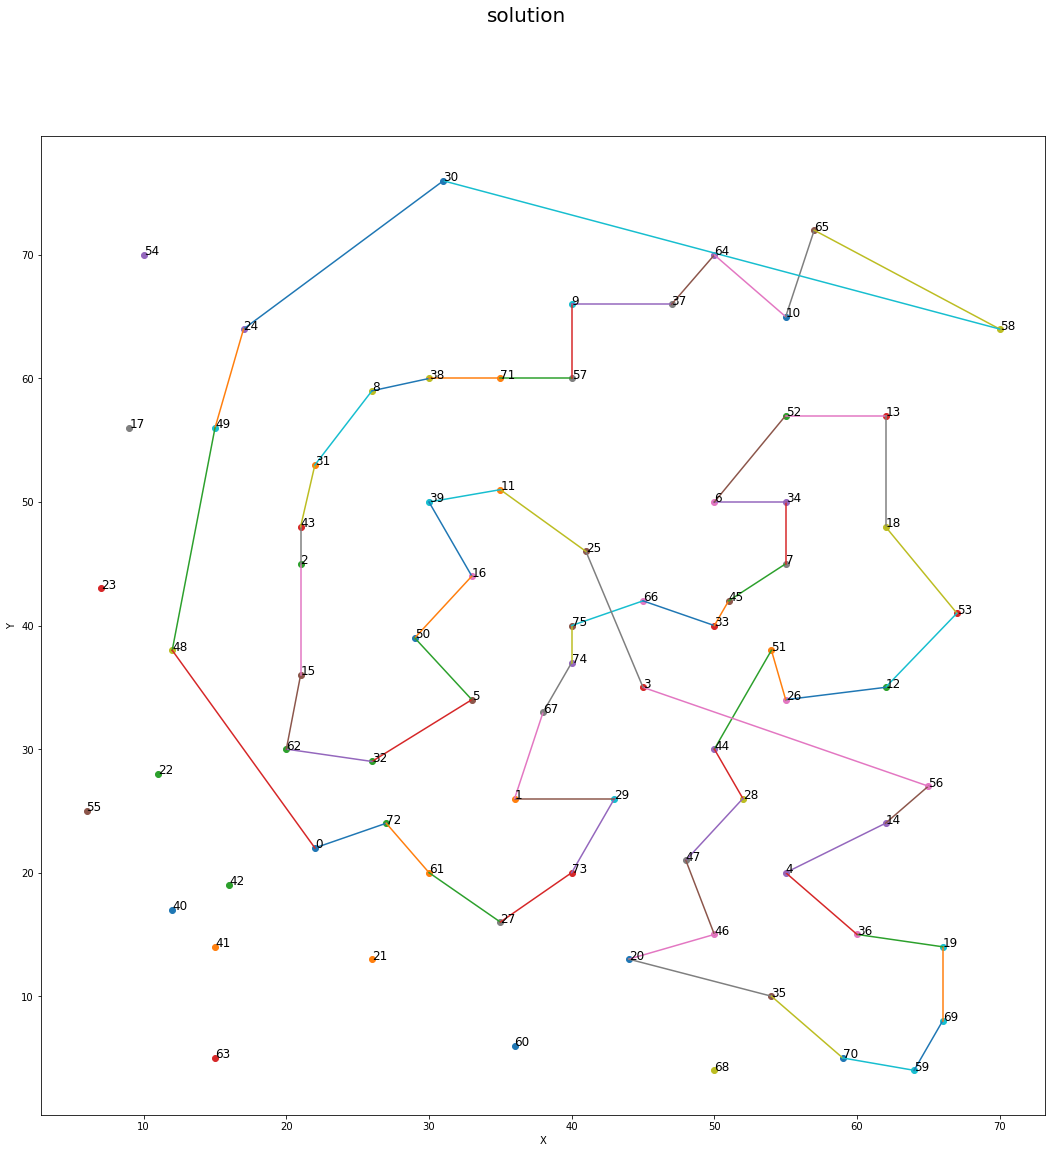

In [ ]:
Tour2 = [0]
def funcScore2(i,T):
    return 1/Dist[(T[-1],i)]
def isValid2(x):
    return Dist[(Tour2[-1], x)] + Dist[(x,0)] <= getTimeLeft(Tour2)
def funcScore3(i,T):
    return score[i]
while True:
    nextNode = getBest(Tour2, funcScore2, isValid2)
    if nextNode is None:
        break
    Tour2.append(nextNode)
gap =  float((bestScore-calcScore(Tour2))*(100/bestScore))
print("Time:",calcTime(Tour2))
print("Score:",calcScore(Tour2))
print("gap(%f%%)" % ( gap ) )
print(Tour2)
greedyOut.append((calcScore(Tour2),gap))
plotTour(Tour2,"solution",18)


### Alg3
Utilizza solo lo score per la scelta

Time: 499.59263280276815
Score: 7296
gap(62.686033%)
[0, 38, 16, 8, 28, 24, 63, 31, 62, 74, 27, 43, 22, 34, 11, 50, 32, 72]


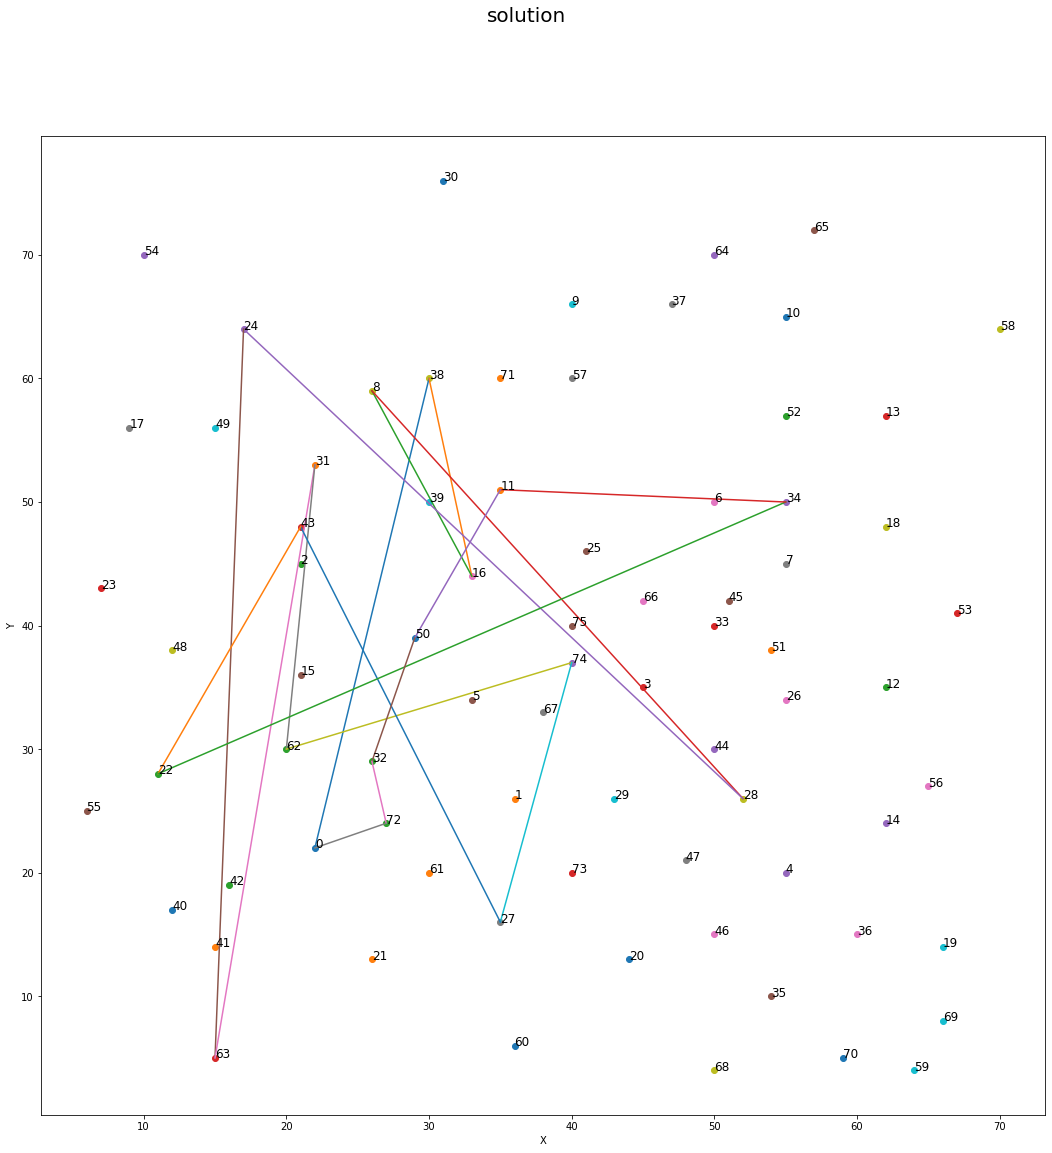

In [ ]:
Tour3 = [0]
def funcScore3(i,T):
    return score[i]
def isValid3(x):
    return Dist[(Tour3[-1], x)] + Dist[(x,0)] <= getTimeLeft(Tour3)

while True:
    nextNode = getBest(Tour3, funcScore3, isValid3)
    if nextNode is None:
        break
    Tour3.append(nextNode)
gap =  float((bestScore-calcScore(Tour3))*(100/bestScore))
print("Time:",calcTime(Tour3))
print("Score:",calcScore(Tour3))
print("gap(%f%%)" % ( gap ) )
print(Tour3)
greedyOut.append((calcScore(Tour3),gap))
plotTour(Tour3,"solution",18)

## Ricerca locale
Un problema degli approcci greedy e che prendono decisioni solamente in base allo stato successivo, ad esempio selezionare il prossimo nodo in base alla distanza minima oppure al massimo punteggio, può portarci in situazioni di stallo, infatti con questo approccio nelle ultime iterazioni dell'algoritmo siamo costretti a prendere i nodi rimanenti anche se non ottimi.

In [ ]:
import itertools

#list(itertools.permutations(s, n)) 
#ha ripetizioni [1,2,3] -> [1,2],[1,3],[2,1],[2,3],[3,2]...

#valuta quale coppia di nodi interni al Tour T
#scambiare con una coppia di nodi esterni
def evalComb(T, comb, seq, pairT): 
    res = list() #lista dei possibili scambi conveniente e validi
    newT = T[:] #copia del Tour
    #comb è la lista del prodotto cartesiano tra gli indici
    #della lista seq(nodi esterni) e pairT(nodi interni)
    #quindi enumera tutti i possibili scambi
    for a,b in comb: #a indice del vettore seq, b indice vettore pairT
        new = seq[a] #coppia nodi da inserire
        old = pairT[b] #coppia nodi da rimuovere
        oldScore =  calcScore(newT)
        oldTime  =  calcTime(newT)
        #possiamo fare cosi la sostituzione dato che per ogni nodo è presente una sola volta nel tour
        n = len(new)
        #sostituiamo old con new
        for i in range(0,n):
            newT[newT.index(old[i])] = new[i]
        #calcolo parametri del nuovo tour
        newScore =  calcScore(newT)
        newTime  =  calcTime(newT)
        #se lo scambio è conveniente ed è valido
        if (newScore/newTime)>(oldScore/oldTime) and newTime<=TMAX:
            #aggiungo lo scambio alla lista dei possibili
            res.append((newScore,newTime, new, old))
        #ripristino il tour originale, per usarlo nelle prossi
        for i in range(0,n):
            newT[newT.index(new[i])] = old[i]
        
    return res

#calcola i possibili scambi tra sequenze di k nodi interni e k nodi esterni
def optIntExt(T,k):
    validNodes = list(set(list(range(NNodes)))-set(T)) #calcolo nodi esterni  
    seq = list(itertools.permutations(validNodes, k))#tutte le possibili coppie di nodi esterni
    #pairT = [(T[i],T[i+1]) for i in range(1,len(T)-1)] #coppie di nodi contigui sul percorso
    pairT = list(itertools.permutations(T[1:], k))#tutte le possibili coppie di nodi interni
    #comb è il prodotto cartesiano tra gli indici della lista seq
    #e della lista pairT, enumera tutti i possibili scambi
    comb = [(a,b) for a,b in itertools.product(list(range(0,len(seq))),list(range(0,len(pairT))))]
    #ho calcolato l'intorno di scambio nodi esterni-interni
    res = evalComb(T,comb,seq,pairT) #valuto i punti dell'intorno
    return res

#scambio L'ordine dei nodi interni
#cercando di abbassare il tempo impiegato
def optIntInt(T):
    #lista dei possibili scambi tra due nodi interni
    #([1,2,3],2) -> [(1, 2), (1, 3), (2, 3)]
    validSwap = list(itertools.combinations(T[1:], 2))
    time = calcTime(T) #tempo del tour attuale
    newT = T[:]
    cI, cJ = -1,-1
    for i,j in validSwap: #itero su tutti gli scambi possibili
        indI = newT.index(i)
        indJ = newT.index(j)
        newT[indI] = j
        newT[indJ] = i
        newTime = calcTime(newT) #tempo del tour dopo lo scambio
        newT[indI] = i #resetto
        newT[indJ] = j
        
        #se lo scambio migliora il tempo
        #rispetto allo scambio precedente
        if newTime<time: 
            #newTime = time
            time = newTime
            cI = indI
            cJ = indJ
            
    #restituisco gli indici da scambiare
    return cI,cJ
            
def tryAdd(T):
    time = calcTime(T)
    if time<TMAX: #se posso aggiungere qualcosa
        validNodes = list(set(list(range(NNodes)))-set(T)) #calcolo nodi esterni  
        #ogni nodo eserno posso inserirlo dopo un nodo già nel percorso, devo capire dove
        comb = [(a,b) for a,b in itertools.product(T,validNodes)] #combinazioni di aggiunte
        #[..a,c..] ->  [..a,b,c..]
        newT = T[:]
        nI,nJ, nScore = -1,-1,-1
        #itero sui possibili inserimenti del nodo j come successivo del nodo i
        for i,j in comb:
            cI = newT.index(i) 
            newT.insert(cI+1, j) #inserisco dopo il nodo i il nodo j
            newTime = calcTime(newT)
            newScore = calcScore(newT)
            #se l'inserimento è valido e conveniente rispetto
            #all'inserimento precedente
            if newTime<=TMAX and newScore>nScore:
                nI,nJ,nScore = cI+1,j,newScore
            newT.remove(j)
            
        return nI,nJ,nScore
    return -1,-1,-1





In [ ]:
optOut = []
def localSearch(tourToOpt, count = 60, p = 1, showOutput = False):
    
    newT = tourToOpt[:]
    oldT = newT[:]
    
    while count>=0:
        mossa = list()

        #provo a scambiare p nodi interni con p esterni
        res = optIntExt(newT,p)
        if len(res) >= 1: #se esiste uno scambio possibile
            m = max(res,key=lambda item:item[0]) #prendi il migliore
            #(newScore,newTime,new,old)
            new = m[2] #(nodo1,..,nodop) i nodi che entrano
            old = m[3] #(nodo1,..,nodop) i nodi che escono
            oldS = ", ".join(str(n) for n in old) 
            newS = ",".join(str(n) for n in new) 
            n = len(new) #quanti nodi devo sostituire
            #sostituisco i p nodi vecchi con i p nuovi
            for i in range(0,n):
                newT[newT.index(old[i])] = new[i]
            mossa.append("INTEXT (%s) -> (%s)" % (oldS,newS))

        #provo ad aggiungere un nodo esterno
        K = tryAdd(newT) #K = (cI+1,j,newScore) = dove inserire, cosa inserire, score nuovo
        if K[0] != -1 and K[1] != -1:
            newT.insert(K[0],K[1])
            mossa.append("ADD (%d -> %d)" % (newT[K[0]-1],K[1]))
            
        #provo ad invertire un nodo interno con un altro interno
        #(cerco di migliorare il costo del cammino già esistente)
        cI,cJ = optIntInt(newT)
        if cI != -1 and cJ != -1: 
            newT[cI], newT[cJ] = newT[cJ], newT[cI]
            mossa.append("INTINT (%d) <-> (%d)" % (newT[cJ],newT[cI]))
            
        if len(mossa)==0: #non ci sono state modifiche
            break
        if showOutput:
            print("----------------------------------------")
            print(", ".join(mossa))
            print("Actual score: %f, Actual time: %f, NNodes: %d" % (calcScore(newT),calcTime(newT),len(newT)))
            print(newT)
        count = count - 1
        
    return (newT,count)
import time
def localOpt(Tour,maxIteraz, p=1, showOutput=False, showPlot = False):
    oldScore = calcScore(Tour)
    print("BEST:  score(%f), time(%f), nnodes(%d)" % (bestScore,calcTime(bestTour),len(bestTour)))
    print("START: score(%f), time(%f), nnodes(%d)" % (oldScore,calcTime(Tour),len(Tour)))
    print("TOUR: ",Tour)
    start_time = time.time()
    optTour,k = localSearch(Tour,maxIteraz,p, showOutput)
    newScore = calcScore(optTour)
    print("\n\noptTour:",optTour)
    print("END:   score(%f), time(%f), nnodes(%d)" % (newScore,calcTime(optTour),len(optTour)))
    print("\t%d iteration, %s seconds" % (maxIteraz-k,time.time() - start_time))
    oldGap = float((bestScore-oldScore)*(100/bestScore))
    newGap = float((bestScore-newScore)*(100/bestScore))
    print("\told gap(%f%%), new gap(%f%%)" % ( oldGap, newGap ) )
    optOut.append((newScore,newGap))
    if showPlot:
        plotTour(Tour,"old solution",18)
        plotTour(optTour,"new solution",18)

In [ ]:
localOpt(Tour1,200,p=1, showOutput = True)

BEST:  score(19553.000000), time(499.618108), nnodes(71)
START: score(17148.000000), time(494.315208), nnodes(51)
TOUR:  [0, 62, 22, 42, 41, 63, 27, 61, 32, 15, 43, 31, 8, 38, 71, 57, 9, 64, 10, 52, 34, 51, 26, 28, 44, 74, 67, 16, 11, 25, 66, 33, 45, 12, 19, 36, 59, 70, 35, 20, 73, 29, 3, 50, 5, 24, 17, 54, 23, 48, 72]
----------------------------------------
INTEXT (5) -> (39), ADD (9 -> 65), INTINT (17) <-> (54)
Actual score: 17365.000000, Actual time: 482.492582, NNodes: 52
[0, 62, 22, 42, 41, 63, 27, 61, 32, 15, 43, 31, 8, 38, 71, 57, 9, 65, 64, 10, 52, 34, 51, 26, 28, 44, 74, 67, 16, 11, 25, 66, 33, 45, 12, 19, 36, 59, 70, 35, 20, 73, 29, 3, 50, 39, 24, 54, 17, 23, 48, 72]
----------------------------------------
INTEXT (3) -> (5), ADD (9 -> 30), INTINT (65) <-> (64)
Actual score: 17680.000000, Actual time: 491.549756, NNodes: 53
[0, 62, 22, 42, 41, 63, 27, 61, 32, 15, 43, 31, 8, 38, 71, 57, 9, 30, 64, 65, 10, 52, 34, 51, 26, 28, 44, 74, 67, 16, 11, 25, 66, 33, 45, 12, 19, 36, 59,

In [ ]:
localOpt(Tour2,30,p=1)

BEST:  score(19553.000000), time(499.618108), nnodes(71)
START: score(17008.000000), time(499.968871), nnodes(64)
TOUR:  [0, 72, 61, 27, 73, 29, 1, 67, 74, 75, 66, 33, 45, 7, 34, 6, 52, 13, 18, 53, 12, 26, 51, 44, 28, 47, 46, 20, 35, 70, 59, 69, 19, 36, 4, 14, 56, 3, 25, 11, 39, 16, 50, 5, 32, 62, 15, 2, 43, 31, 8, 38, 71, 57, 9, 37, 64, 10, 65, 58, 30, 24, 49, 48]


optTour: [0, 72, 61, 27, 73, 29, 1, 67, 74, 75, 66, 33, 45, 7, 34, 6, 52, 13, 18, 53, 12, 51, 26, 44, 28, 47, 20, 46, 35, 70, 59, 69, 19, 36, 4, 14, 56, 3, 25, 11, 39, 16, 50, 5, 32, 62, 15, 2, 43, 31, 8, 38, 71, 57, 9, 37, 64, 10, 58, 65, 30, 24, 17, 23, 48, 22]
END:   score(18005.000000), time(499.492963), nnodes(66)
	4 iteration, 0.6739866733551025 seconds
	old gap(13.015905%), new gap(7.916944%)


BEST:  score(19553.000000), time(499.618108), nnodes(71)
START: score(7296.000000), time(499.592633), nnodes(18)
TOUR:  [0, 38, 16, 8, 28, 24, 63, 31, 62, 74, 27, 43, 22, 34, 11, 50, 32, 72]


optTour: [0, 22, 42, 41, 63, 21, 27, 73, 29, 28, 44, 26, 3, 74, 67, 5, 32, 62, 15, 50, 16, 25, 66, 33, 45, 6, 9, 30, 37, 64, 65, 10, 13, 52, 34, 57, 71, 38, 8, 24, 54, 17, 49, 31, 43, 39, 11, 51, 12, 56, 14, 36, 19, 69, 59, 70, 35, 46, 20, 61, 72]
END:   score(18394.000000), time(498.484440), nnodes(61)
	43 iteration, 4.391019582748413 seconds
	old gap(62.686033%), new gap(5.927479%)


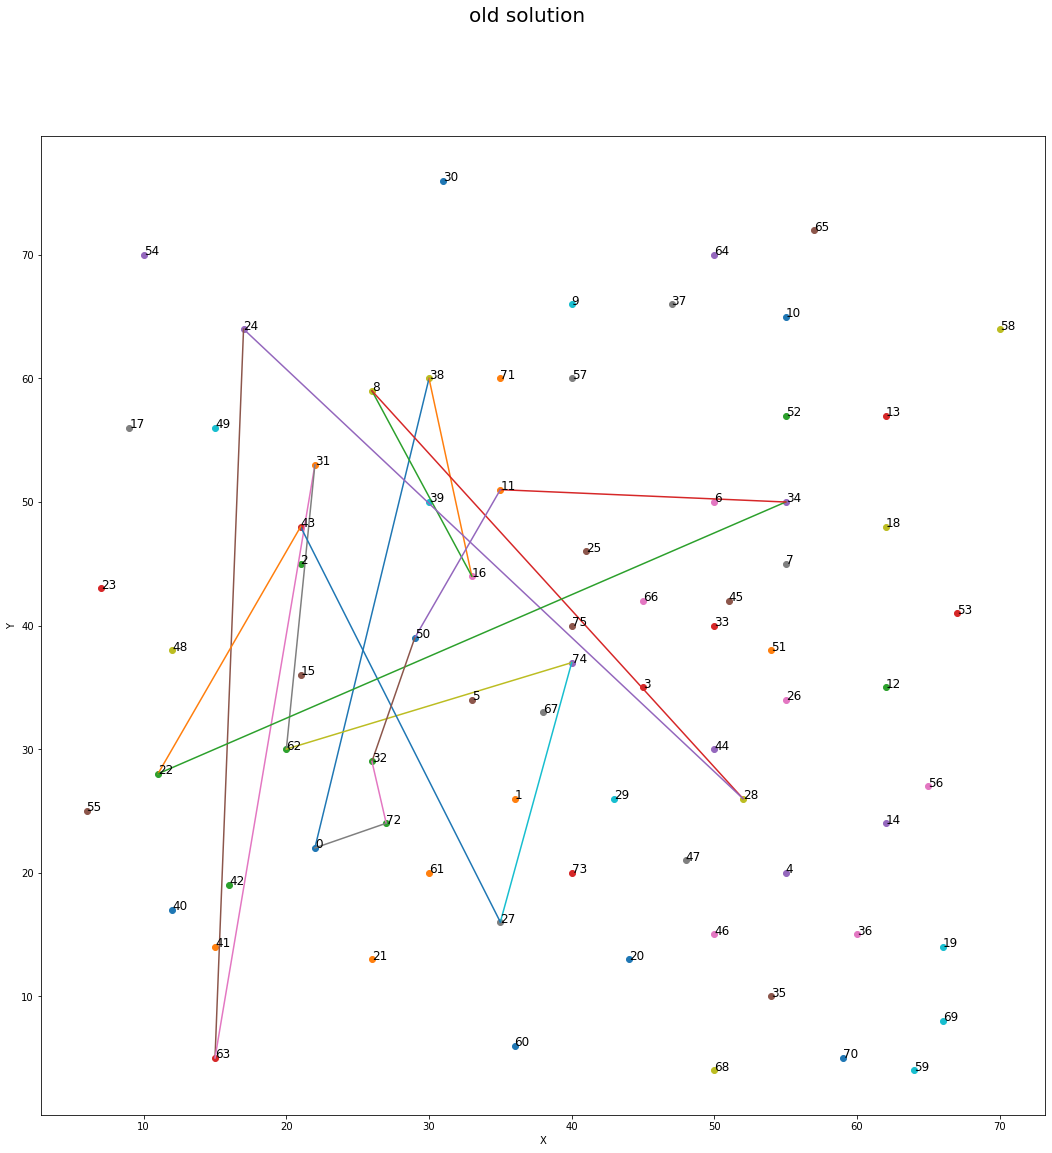

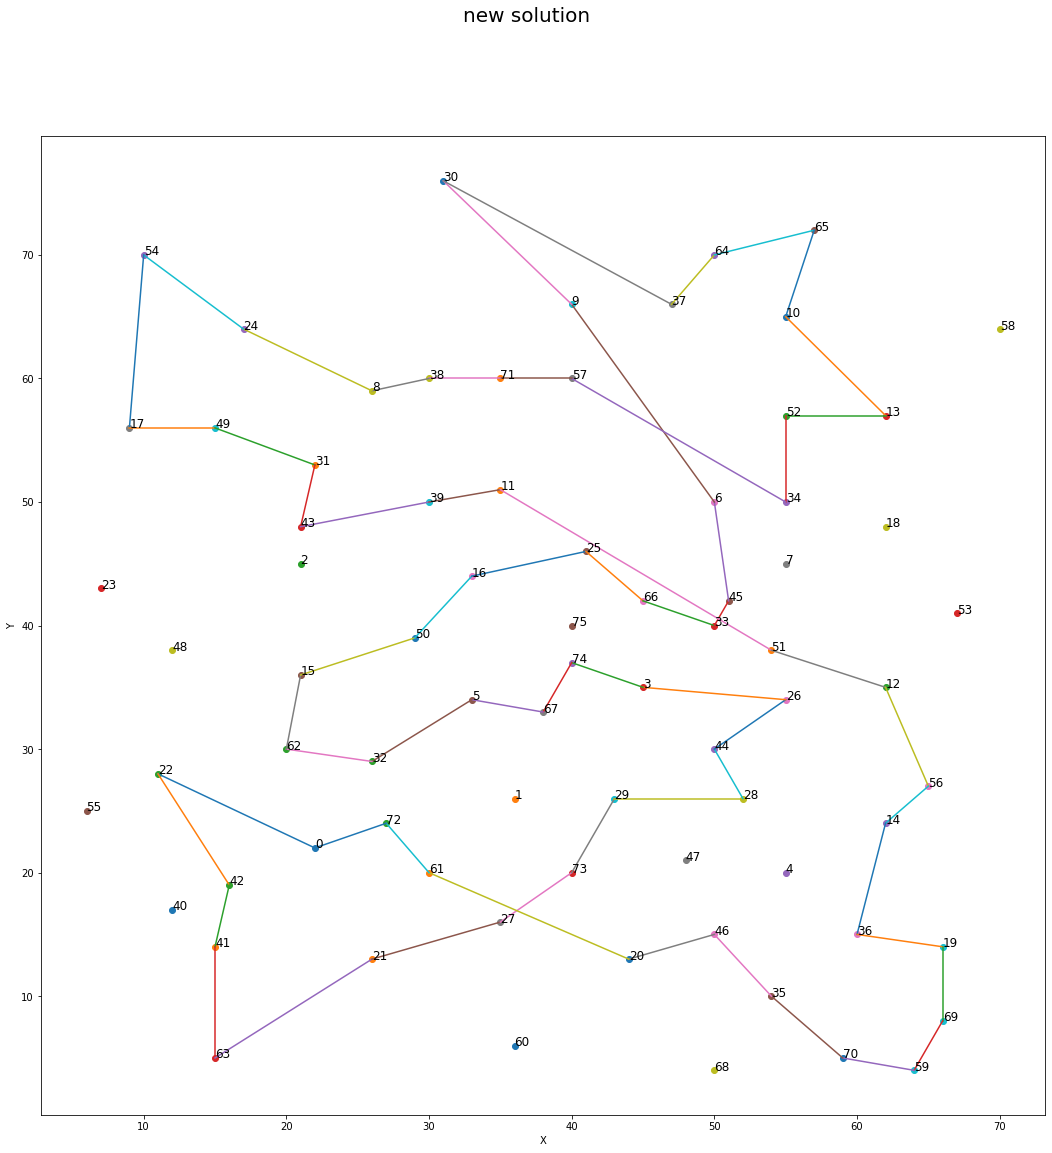

In [ ]:
localOpt(Tour3,200,p=1,showPlot=True)

In [ ]:
print("Best: %f\n"%(bestScore))
for i in range(3):
    print("Euristica ",i+1)
    print("Greedy: score %f, gap %f %%"%(greedyOut[i][0], greedyOut[i][1]))
    print("Search: score %f, gap %f %%"%(optOut[i][0], optOut[i][1]))
    print("\n")

Best: 19553.000000

Euristica  1
Greedy: score 17148.000000, gap 12.299903 %
Search: score 18597.000000, gap 4.889275 %


Euristica  2
Greedy: score 17008.000000, gap 13.015905 %
Search: score 18005.000000, gap 7.916944 %


Euristica  3
Greedy: score 7296.000000, gap 62.686033 %
Search: score 18394.000000, gap 5.927479 %


